# Home 3: Build a CNN for image recognition.

### Name: Christopher Hittner

I pledge my honor that I have abided by the Stevens Honor System.


## 1. Data preparation

### 1.1. Load data


shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


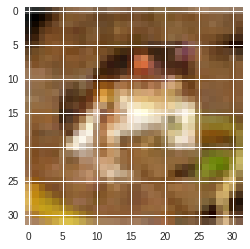

In [17]:
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy
%matplotlib inline


(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(numpy.max(y_train) - numpy.min(y_train) + 1))

plt.imshow(x_train[0])
plt.show()

# Scale the input to [0,1]
x_train = x_train / 255.
x_test = x_test / 255.

### 1.2. One-hot encode the labels

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. However, such labels are not easily trainable and it is thus easier to train on an encoding of the labels. Here, a one-hot encoding is used for this purpose.

In [3]:
from keras.utils import to_categorical

def to_one_hot(y, num_class=10):
    return to_categorical(y)

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


### 1.3. Randomly partition the training set to training and validation sets

Randomly partition the 50K training samples to 2 sets:
* a training set containing 40K samples
* a validation set containing 10K samples


In [4]:
rand_indices = numpy.random.permutation(50000)
train_indices = rand_indices[0:40000]
valid_indices = rand_indices[40000:50000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)


### 1.4. Perform Data Augmentation

To increase the model accuracy, I used data augmentation to increase the amount of data available to the model. Fortunately, Keras provides a ```model.fit_generator()``` utility. To make use of this, I used the ImageDataGenerator class to generate the samples.


In [0]:
from keras.preprocessing.image import ImageDataGenerator

# Image generator for training
def make_generator(X):
    gen = ImageDataGenerator(
            rotation_range=40,
            zoom_range=0.2,
            shear_range=0.2,
            width_shift_range=0.2,
            height_shift_range=0.2,
            fill_mode='nearest',
            horizontal_flip=True,
    )
    gen.fit(X)
    return gen

# Create a generator for the training data
gen = make_generator(x_tr)

## 2. Build a CNN and tune its hyper-parameters

1. Build a convolutional neural network model
2. Use the validation data to tune the hyper-parameters (e.g., network structure, and optimization algorithm)
    * Do NOT use test data for hyper-parameter tuning!!!
3. Try to achieve a validation accuracy as high as possible.

### Remark: 

The following CNN is just an example. You are supposed to make **substantial improvements** such as:
* Add more layers.
* Use regularizations, e.g., dropout.
* Use batch normalization.

In [6]:
from keras.layers import *
from keras.models import Model, Sequential

def add_skip_connection(model, input_shape=None):
    input_shape = input_shape or model.output_shape[1:]
    
    # Input to the residual block
    x = Input(shape=input_shape)
    
    trace = Sequential()
    
    trace.add(BatchNormalization(input_shape=input_shape))
    trace.add(Activation('relu'))
    trace.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
    
    trace.add(BatchNormalization())
    trace.add(Activation('relu'))
    trace.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
    
    y = trace(x)
    
    residual_block = Model(x, Add()([x, y]))
    
    model.add(residual_block)
    

def make_model():
    model = Sequential()
    

    model.add(Conv2D(64, (7, 7), padding='same', input_shape=(32, 32, 3)))
    
    # We will reduce the dimensionality 3 times
    for _ in range(3):
        # At each level, we will have three tiers of residual blocks
        for _ in range(2):
            add_skip_connection(model)
            
        # We will also reduce to half size
        model.add(MaxPooling2D((2, 2)))
    
    """
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    #model.add(Dropout(0.5))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    
    #model.add(Dropout(0.5))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    #model.add(Dropout(0.5))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    """

    model.add(Flatten())

    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))

    model.add(Dense(10, activation='softmax'))
    
    return model

model = make_model()

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        9472      
_________________________________________________________________
model_1 (Model)              (None, 32, 32, 64)        74368     
_________________________________________________________________
model_2 (Model)              (None, 32, 32, 64)        74368     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
model_3 (Model)              (None, 16, 16, 64)        74368     
_________________________________________________________________
model_4 (Model)      

In [0]:
from keras import optimizers

learning_rate = 2E-4 # to be tuned!


model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=learning_rate),
              metrics=['acc'])

In [8]:
history = model.fit_generator(gen.flow(x_tr, y_tr, batch_size=32),
                              steps_per_epoch=len(x_tr) // 32, epochs=64,
                              validation_data=(x_val, y_val))

Instructions for updating:
Use tf.cast instead.
Epoch 1/64
1250/1250 [==============================] - 96s 77ms/step - loss: 2.0448 - acc: 0.2698 - val_loss: 1.7415 - val_acc: 0.3645
Epoch 2/64
1250/1250 [==============================] - 82s 66ms/step - loss: 1.7279 - acc: 0.3659 - val_loss: 1.7410 - val_acc: 0.3580
Epoch 3/64
1250/1250 [==============================] - 82s 66ms/step - loss: 1.5971 - acc: 0.4203 - val_loss: 1.4912 - val_acc: 0.4671
Epoch 4/64
1250/1250 [==============================] - 82s 66ms/step - loss: 1.4789 - acc: 0.4644 - val_loss: 1.3400 - val_acc: 0.5264
Epoch 5/64
1250/1250 [==============================] - 82s 66ms/step - loss: 1.3890 - acc: 0.4954 - val_loss: 1.4440 - val_acc: 0.4926
Epoch 6/64
1250/1250 [==============================] - 83s 66ms/step - loss: 1.3136 - acc: 0.5232 - val_loss: 1.2327 - val_acc: 0.5494
Epoch 7/64
1250/1250 [==============================] - 82s 66ms/step - loss: 1.2512 - acc: 0.5537 - val_loss: 1.2696 - val_acc: 0.5616


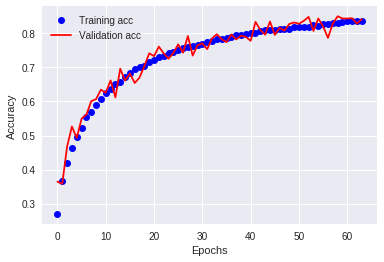

In [9]:
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

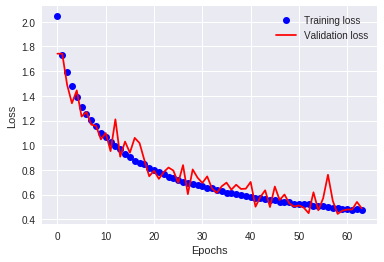

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 3. Train (again) and evaluate the model

- To this end, you have found the "best" hyper-parameters. 
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### 3.1. Train the model on the entire training set

Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [0]:
model = make_model()

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=learning_rate),
              metrics=['acc'])

In [15]:
gen = make_generator(x_train)

model.fit_generator(gen.flow(x_train, y_train_vec, batch_size=32),
                    steps_per_epoch=len(x_train) // 32, epochs=64)

Epoch 1/64
1562/1562 [==============================] - 117s 75ms/step - loss: 2.0236 - acc: 0.2875
Epoch 2/64
1562/1562 [==============================] - 98s 63ms/step - loss: 1.6913 - acc: 0.3768
Epoch 3/64
1562/1562 [==============================] - 98s 63ms/step - loss: 1.5522 - acc: 0.4360
Epoch 4/64
1562/1562 [==============================] - 98s 63ms/step - loss: 1.4358 - acc: 0.4779
Epoch 5/64
1562/1562 [==============================] - 99s 63ms/step - loss: 1.3355 - acc: 0.5167
Epoch 6/64
1562/1562 [==============================] - 98s 63ms/step - loss: 1.2519 - acc: 0.5509
Epoch 7/64
1562/1562 [==============================] - 98s 63ms/step - loss: 1.1834 - acc: 0.5786
Epoch 8/64
1562/1562 [==============================] - 99s 63ms/step - loss: 1.1245 - acc: 0.5994
Epoch 9/64
1562/1562 [==============================] - 98s 63ms/step - loss: 1.0744 - acc: 0.6206
Epoch 10/64
1562/1562 [==============================] - 99s 63ms/step - loss: 1.0327 - acc: 0.6364
Epoch 11

### 3.2. Evaluate the model on the test set

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [18]:
loss_and_acc = model.evaluate(x_test, y_test_vec)
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))

10000/10000 [==============================] - 6s 585us/step
loss = 0.4847667139053345
accuracy = 0.839


### Final Notes

In this notebook, I acknowledge that the order in which things were run may appear strange (certain things are out of order). However, I assure the reader that the contents were run legitimately, and that the integrity of the test set was never compromised.